In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math
import subsampling as ss
import seaborn as sns
import imp

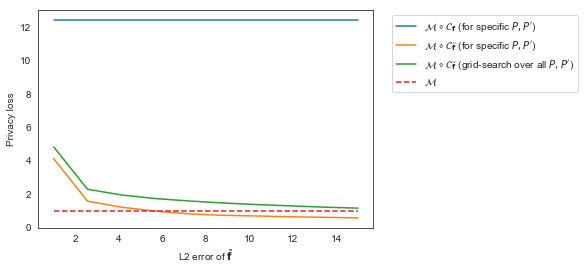

In [5]:
# Figure 3: error vs. amplification
imp.reload(ss)

# Common parameters
total_sample_size = 2000
eps0 = 1
num_iters = 10
eps_upper = 10

# Min/max sizes/stds for rest of the strata
rest_min_pop_size_list = [66500, 21870, 15190, 3700, 1990, 510, 180]
rest_max_pop_size_list = [66520, 21890, 15210, 3720, 2010, 530, 200]
rest_min_pop_std_list = [0.1, 1, 2, 10, 35, 60, 130]
rest_max_pop_std_list = [1, 2, 5, 20, 50, 80, 160]

# Parameters for stratum in question
min_pop_std = 1
max_pop_std = 10
min_pop_size = 10800
max_pop_size = 10900 

# Realizable neighboring strata
data_lb = 20
data_ub = 49
data_range = data_ub - data_lb
s1_size = min_pop_size +2 
s1_std = max_pop_std 
s1p_size = s1_size+1
s1p_std = s1_std - ss.max_diff_std(data_range, s1_size)

# Non-instance-dependent min and max sample sizes for stratum in question
_, utility_lb, utility_ub = ss.compute_gs(total_sample_size, min_pop_size, min_pop_std, max_pop_size, max_pop_std, 
                                   rest_min_pop_size_list, rest_min_pop_std_list, 
                                   rest_max_pop_size_list, rest_max_pop_std_list)
# utility_lb = int(utility_lb)
# utility_ub = int(utility_ub)
# print("utility lb ub:", utility_lb, utility_ub)

# List of target errors 
error_list = np.linspace(1.01, 15.0, 10)
eps_lb_res = []
eps_ad_lb_res = []
eps_ad_lb_worst_res = []
for i in range(len(error_list)):
    
    # Adjust target error by 1/eps0 to account for error of eps0-Laplace mechanism M
    target_error = error_list[i]
    adjusted_target_error = target_error  - (1./eps0)

    # -------  Neyman allocation + Laplace (baseline) ------------------------------------
    
    # Get sample sizes for realizable neighboring stratum; fix other strata to have min size/std parameters 
    m1, m1p = ss.get_sizes(total_sample_size, s1_size, s1_std, s1p_size, s1p_std, rest_min_pop_size_list, 
                        rest_min_pop_std_list, rest_min_pop_size_list, rest_min_pop_std_list)
    # Compute log ratio between Laplace distributions
    eps_lb = ss.compute_lb_eps(eps0, m1, m1p)
    eps_lb_res.append(eps_lb)
                      
    # -------  Noisy Neyman allocation + Laplace (lower bounds) -----------------------------------
    
    # instance specific privacy loss by inverting error vs. privacy lower bound
    ad_lb_error = max(adjusted_target_error, 0.001)
    eps_ad_lb = ss.eps_search_ad(max_pop_size, ad_lb_error, num_iters, eps_upper, data_range, total_sample_size, s1_size, s1_std, 
               rest_min_pop_size_list, rest_min_pop_std_list, rest_min_pop_size_list, rest_min_pop_std_list)
    eps_ad_lb_res.append(eps_ad_lb)
    
    # grid-search privacy loss by inverting error vs. privacy lower bound
    num_sizes = 5 
    num_stds = 5
    eps_ad_lb_worst = ss.worst_case_ad_grid_search(adjusted_target_error, num_iters, eps_upper, data_range, 
                                                   total_sample_size, min_pop_size, max_pop_size, num_sizes, 
                                                   min_pop_std, max_pop_std, num_stds, 
                                                   rest_min_pop_size_list, rest_min_pop_std_list)
    eps_ad_lb_worst_res.append(eps_ad_lb_worst)

sns.set_style("white")
plt.plot(error_list, eps_lb_res, label=r"$\mathcal{M} \circ \mathcal{C}_{\mathbf{f}}$ (for specific $P, P'$)")
plt.plot(error_list, eps_ad_lb_res, label=r"$\mathcal{M} \circ \mathcal{C}_{\tilde{\mathbf{f}}}$ (for specific $P, P'$)")
plt.plot(error_list, eps_ad_lb_worst_res, label=r"$\mathcal{M} \circ \mathcal{C}_{\tilde{\mathbf{f}}}$ (grid-search over all $P, P'$)")
plt.plot(error_list, [eps0]*len(error_list), linestyle='dashed', label=r"$\mathcal{M}$")
plt.xlabel(r"L2 error of $\tilde{\mathbf{f}}$")
plt.ylabel("Privacy loss")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize='10', numpoints=1)

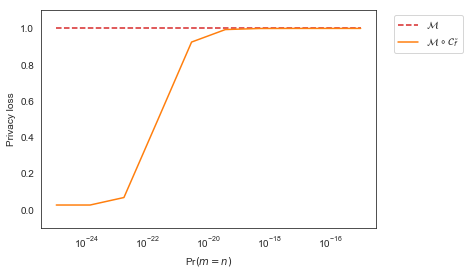

In [9]:
# Figure 4: concentration vs. amplification
imp.reload(ss)

n = 100
eps = 1.0
p1 = (n/2.0)/n
p2 = (n/2.0 + 1.0)/n
fixed_tail = n
tail_prob_list = np.logspace(-25, -15, 10) 

new_eps_tails = []
for i in range(len(tail_prob_list)):
    tail_prob = tail_prob_list[i]
    ftilde1 = [(2, 1.0- tail_prob), (fixed_tail, tail_prob)]
    # Pass in ftilde1 for both datasets because sample size should not be data-dependent
    new_eps = ss.computeAmp(n, eps, p1, p2, ftilde1, ftilde1) 
    new_eps_tails.append(new_eps)
    
sns.set_style('white')
x_list = tail_prob_list
plt.plot(x_list, [eps]*len(x_list), linestyle='dashed', color='tab:red', label=r'$\mathcal{M}$')
plt.plot(x_list, new_eps_tails, color='tab:orange', label=r'$\mathcal{M} \circ \mathcal{C}_{\tilde{f}}$')
plt.xscale('log')
plt.ylim(-0.1, 1.1)
plt.xlabel(r"Pr$(m=n)$")
plt.ylabel(r"Privacy loss") 
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize='10')